In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

path = '../Data/'
K = np.loadtxt(path + 'K.txt')


## gray scale them
im0 = cv2.imread(path + 'sequence/000001.png')[:,:,::-1]
im1 = cv2.imread(path + 'sequence/000002.png')[:,:,::-1]
im2 = cv2.imread(path + 'sequence/000003.png')[:,:,::-1]


##im0 = im0/255
#im1 = im1/255
#im2 = im2/255

### Exercise 11.1
- Find SIFT keypoints (kp0, kp1, kp2) in all three images and compute their corresponding descrip-
tors (des0, des1, des2).

- For speed reasons, you can limit the number of SIFT features to 2000.

- Convert the features to numpy arrays of 2D points kp = np.array([k.pt for k in kp])

- Match the SIFT features between im0 and im1 (matches01), and between im1 and im2 (matches12).

- Convert the matches to numpy arrays of the indices


* matches = np.array([(m.queryIdx, m.trainIdx) for m in matches])

In [2]:
sift = cv2.SIFT_create(nfeatures = 2000)

#LIMIT THE NUMBER OF FEATURES TO 2000

kp0_0, des0 = sift.detectAndCompute(im0,None)
kp1_1, des1 = sift.detectAndCompute(im1,None)
kp2_2, des2 = sift.detectAndCompute(im2,None)


kp0 = np.array([k.pt for k in kp0_0])
kp1 = np.array([k.pt for k in kp1_1])
kp2 = np.array([k.pt for k in kp2_2])


kp0 = kp0[:2000]
kp1 = kp1[:2000]
kp2 = kp2[:2000]

des0 = des0[:2000]
des1 = des1[:2000]
des2 = des2[:2000]

# MATCH THE FEATURES 
bf = cv2.BFMatcher(crossCheck = True)

matches = bf.match(des0,des1)
matches12_ = bf.match(des1,des2)

matches01 = np.array([(m.queryIdx,m.trainIdx) for m in matches])
matches12 = np.array([(m.queryIdx,m.trainIdx) for m in matches12_])

### Exercise 11.2

* Estimate the essential matrix between im0 and im1 with RANSAC. You can use the OpenCV
function cv2.findEssentialMat to do this. 
* The mask returned by this function indicates which
of the matches are inliers.


* Decompose the essential matrix and find the correct relative pose (R1, t1). For this we can again
use an OpenCV function namely cv2.recoverPose.


* The mask returned by cv2.recoverPose indicates which matches, that lie in front of both cameras.


* Combine this mask with the mask from cv2.findEssentialMat, to get the matches that are both

In [3]:
#Estimate the essential matrix between im0 and im1 with RANSAC. 
E01, mask01= cv2.findEssentialMat(kp0[matches01[:,0]],kp1[matches01[:,1]],K,method=cv2.RANSAC)
_, R01, t01, mask_pose = cv2.recoverPose(E01,kp0[matches01[:,0]],kp1[matches01[:,1]],K)

combined_mask = (mask01*mask_pose).astype(bool).flatten()

matches01 = np.array(matches01)[combined_mask]

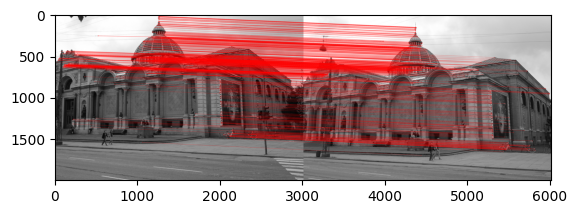

(<matplotlib.image.AxesImage at 0x207e14c6b60>, None)

In [4]:
both_images = cv2.drawMatches(im0, kp0_0, im1, kp1_1, np.array(matches)[combined_mask], None,(255,0,0),flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#%matplotlib qt

plt.imshow(both_images),plt.show()

### Exercise 11.3

Use matches01 and matches12 and find the subset of matches such that we can match features
all the way from image 0 to image 2. In other words, create three lists such that points0[i],
points1[i], and points2[i] are the 2D locations of the same point in the corresponding images.
For this you can use

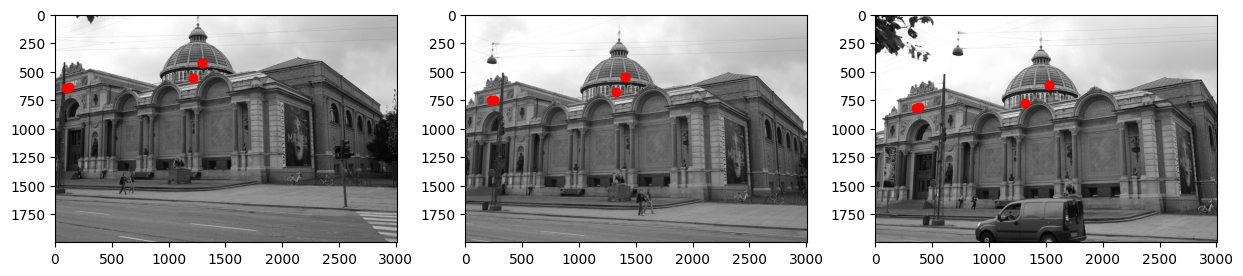

In [5]:

_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)


points0 = kp0[matches01[idx01,0]]
points1 = kp1[matches01[idx01,1]]
points2 = kp2[matches12[idx12,1]]


## Let's plot the first 5 results 

fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(im0,cmap='gray')
ax[0].scatter(points0[25:30,0],points0[25:30,1],color='r')
ax[1].imshow(im1,cmap='gray')
ax[1].scatter(points1[25:30,0],points1[25:30,1],color='r')
ax[2].imshow(im2,cmap='gray')
ax[2].scatter(points2[25:30,0],points2[25:30,1],color='r')
plt.show()

## Point triangulation 



### Exercise 11.4

* For the points that have been tracked through all three images, use the 2D positions in image 0
and 1 to triangulate the points in 3D (Q). 

* Using the 2D positions in image 
2, estimate the pose
of image 2 with RANSAC.  Use cv2.solvePnPRansac to do this. As the lens distortion is already
corrected, you can set distCoeffs = np.zeros(5).

* Visualize the 3D points that are also inliers for solvePnPRansac.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*Q[inliers.flatten()])
Also plot the position of the cameras. 

- Recall that the position of the camera is not the translation.
How do you find the position

In [6]:
from some import add_project_root_to_path
add_project_root_to_path()
from utils.functions_10 import * 

In [7]:
R0 = np.eye(3)
t0 = np.zeros((3,1 ))
P0 = K @ np.hstack((R0,t0))
P1 = K @ np.hstack((R01,t01)) # Projection matrix for image 1 and 0 

Q = cv2.triangulatePoints(P0,P1,points0.T,points1.T)

Q /= Q[3]
Q = objectPoints = Q[:3].T.reshape(-1, 1, 3)

imagePoints = points2.reshape(-1, 1, 2)



_, rvec, tvec, inliers = cv2.solvePnPRansac(Q, imagePoints, K, distCoeffs=np.zeros(5))
R2 = cv2.Rodrigues(rvec)[0] 

Using the 2D positions in image 2, estimate the pose
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this. As the lens distortion is already
corrected, you can set distCoeffs = np.zeros(5).

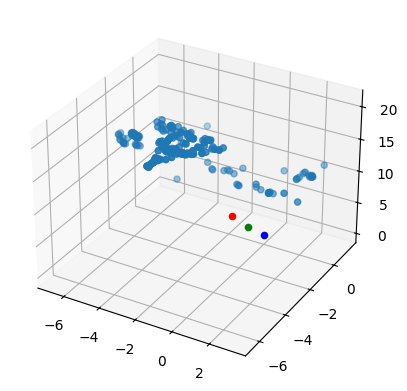

In [8]:

pos0 = R0.T @ (-t0)
pos1 = R01.T @ (-t01) 
pos2 = R2.T @ (-tvec)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*Q[inliers.flatten()].T)
#The positions of the cameras
ax.scatter(*pos2,color='r')
ax.scatter(*pos0,color='b')
ax.scatter(*pos1,color='g')

In [9]:
import plotly.graph_objects as go

def plot_3d_points_and_cameras(Q, camera_positions, inliers):
    """
    Plots 3D points and camera positions using Plotly.

    :param Q: Numpy array of 3D points, shape (3, N).
    :param camera_positions: List of numpy arrays, each with shape (3,) representing camera positions.
    :param inliers: Array or list of indices for the inlier points to be plotted.
    """
    inlier_Q = Q[inliers.flatten()]  # Select inliers and ensure the array is properly shaped
    inlier_Q = inlier_Q.reshape(-1, 3)

    fig = go.Figure()

    # Add the triangulated 3D inlier points to the plot
    fig.add_trace(go.Scatter3d(
        x=inlier_Q[:, 0],  # X coordinates
        y=inlier_Q[:, 1],  # Y coordinates
        z=inlier_Q[:, 2],  # Z coordinates
        mode='markers',
        marker=dict(
            size=2,
            color='blue',  # Points color
            opacity=0.8
        ),
        name='Triangulated Points'
    ))

    # Loop through the list of camera positions and add each to the plot
    for i, pos in enumerate(camera_positions):
        fig.add_trace(go.Scatter3d(
            x=pos[0],
            y=pos[1],
            z=pos[2],
            mode='markers',
            marker=dict(
                size=5,
                color='green' if i == 0 else 'red',  # Use different colors for clarity, customize as needed
                opacity=0.8
            ),
            name=f'Camera {i} Position'
        ))

    # Configure the layout
    fig.update_layout(
        title='3D Point Cloud and Camera Positions',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis',
            xaxis=dict(showgrid=True, zeroline=False),
            yaxis=dict(showgrid=True, zeroline=False),
            zaxis=dict(showgrid=True, zeroline=False),
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    # Show the figure
    fig.show()

In [10]:
matches01

array([[  13,  203],
       [  14,  402],
       [  20,  180],
       ...,
       [1973, 1871],
       [1981, 1889],
       [1982, 1955]])

In [11]:
plot_3d_points_and_cameras(Q, [pos0, pos1, pos2], inliers)

### Exercise 11.5

- Iterate through all images in the folder, repeating the steps in Exercises 11.3 and 11.4 for the
previous three images each time.

* Visualize all the 3D points and camera positions. Does it look correct?

In [12]:
import os 
import cv2 
import numpy as np 
from functions_11 import * 


folder = '../Data/sequence'
path = '../Data/'
K = np.loadtxt(path + 'K.txt')

vis_od = VisualOdometry(folder,K)
vis_od.compute_keypoints()
vis_od.compute_matches()
camera_positions = [] 
vis_od.recover_pose(0) # Computes the essential matrix and set the first two poses
p1,p2,p3 = vis_od.chain_feature_matches(2)
Q = vis_od.get_3D_objects(0,p1,p2)


camera_positions.append(vis_od.get_position(0))
camera_positions.append(vis_od.get_position(1))

vis_od.match_features_across_frames()
all_inliers = np.array([])


for i in range(2,len(vis_od.imgs)):

    p1,p2,p3 = vis_od.chain_feature_matches(i)
    Q_new = vis_od.get_3D_objects(i,p1,p2)
    Q= np.append(Q,Q_new)
    imagePoints = p3.reshape(-1, 1, 2)
    R,t,inliers = vis_od.estimatePose_pnp(imagePoints,Q_new)
    if inliers is not None and inliers.size>0: # The last couple of frames has no inliers.. apparently
        all_inliers = np.append(all_inliers,inliers).astype(int)
    else:
        print(i)
        print(inliers)
        
    camera_positions.append(vis_od.get_position(i))

In [13]:
import os 
import cv2 
import numpy as np 
from functions_11 import * 


folder = '../Data/sequence'
path = '../Data/'
K = np.loadtxt(path + 'K.txt')

vis_od = VisualOdometry(folder,K)

In [15]:
vis_od.plot_3d_points_and_cameras(Q.reshape(-1,1,3),camera_positions,all_inliers)

### Exercise 11.6
- Instead of just triangulating the 3D points from the previous two frames, use all frames that the feature has been seen in to triangulate it.

### Exercise 11.7

- Use the calibration you did of your phone and capture your own sequence of images to try out.

### Exercise 11.8
- Implement bundle adjustment after your algorithm has run, where you optimize over the camera
poses and 3D points in all frames at the same time. Does this improve the result?

### Exercise 11.9
- For a more challenging evaluation, you can try your code on a sequence from the KITTI dataset.
- Download KITTI09.zip that contains the images from left camera in sequence 09 in the KITTI dataset, and the corresponding ground truth camera positions and orientations.

- Load the ground truth by running
gt = np.loadtxt('09.txt').reshape(-1, 3, 4)
Now, gt contains the ground truth rotation and position (NOT the pose) of each camera in the sequence. 

- The translations are true to scale, so it’s allowed to scale your positions to match as
good as possible.